In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler



In [3]:
filepath = "RELIANCE_2010-01-012021-08-30.csv"
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2010-01-04,1091.1,1091.1,1021.85,1075.50,17520006,RELIANCE
1,2010-01-05,1149.9,1149.9,1065.40,1070.70,4890040,RELIANCE
2,2010-01-06,1079.9,1094.5,1070.65,1088.00,5415538,RELIANCE
3,2010-01-07,1088.0,1115.0,1078.00,1106.05,5988404,RELIANCE
4,2010-01-08,1108.0,1113.8,1096.00,1103.15,3453926,RELIANCE


In [3]:
# price = data[['Date', 'Close']]

In [4]:
# price.set_index('Date', inplace=True)

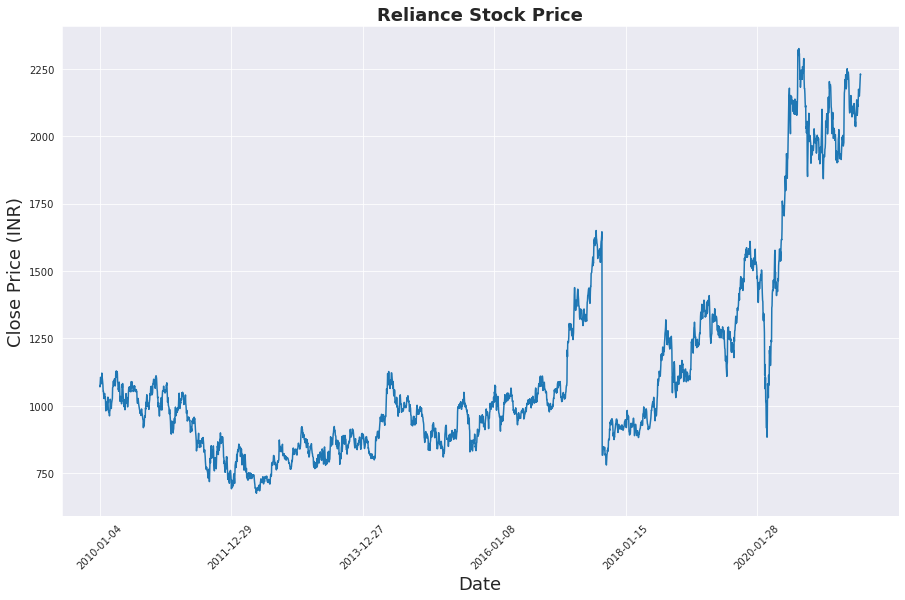

In [4]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title("Reliance Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (INR)',fontsize=18)
plt.show()

In [5]:
price = data[['Close']]

In [6]:
def splitData(ts):

    test_set_size = int(np.round(0.2*len(ts)));
    train_set = ts[:-test_set_size]    
    test_set = ts[-test_set_size:]

    return train_set, test_set


In [7]:
def modify_test_data(test_set, variance):
    
    noise = np.random.normal(0,variance,len(test_set))
    # print("noise", noise[:50])
    modified_test_Set = test_set + noise

    return modified_test_Set


In [8]:
train_set, test_set = splitData(price['Close'].values)
# modified_test_set = modify_test_data(test_set)

In [8]:
#Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# Normalize the training, validation and test set

def normalize_data(train_set, test_set):
    train_norm = scaler.fit_transform(train_set.reshape(-1, 1))
    test_norm = scaler.transform(test_set.reshape(-1, 1))
    
    return train_norm, test_norm

In [9]:
window_size = 20
def prepareDataForTraining(seq):

    x_data = []
    y_data = []
    L = len(seq)
    for i in range(L-window_size):        
        window = seq[i:i+window_size]
        label = seq[i+window_size:i+window_size+1]
        x_data.append(window)
        y_data.append(label)
    return x_data, y_data    

#### R2-score
Source: https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score <br/>
https://en.wikipedia.org/wiki/Coefficient_of_determination

R-squared or Correlation of determination score for Regression-
    <ul>
        <li>In regression, the R2 coefficient of determination is a statistical measure of how well the regression predictions approximate the real data points. 
        <li> R2 = 1 (best score), R2 = 0( model does not capture any variability in the data), R2 = negative (model chmodel can be arbitrarily worse)
    </ul>

### Check characteristics of Time Series

#### Check if data has Normal Distribution: Histogram, QQ-Plot and KS-Test

(array([ 473., 1037.,  591.,  229.,  160.,  106.,   14.,   96.,  128.,
          61.]),
 array([ 676.1  ,  840.945, 1005.79 , 1170.635, 1335.48 , 1500.325,
        1665.17 , 1830.015, 1994.86 , 2159.705, 2324.55 ]),
 <BarContainer object of 10 artists>)

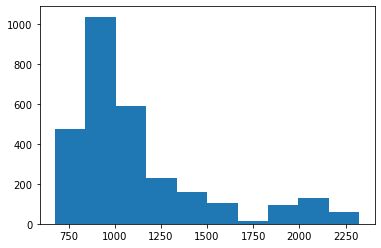

In [10]:
plt.hist(price)

/home/ambekar/anaconda3/envs/safeml/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


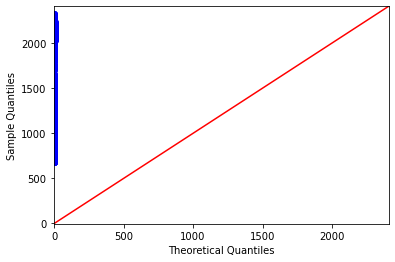

In [11]:
import statsmodels.api as sm

sm.qqplot(price, line='45');


In [13]:
from scipy.stats import kstest, norm

loc, scale = norm.fit(price)

In [14]:
loc, scale

(1122.0880138169257, 372.3690428953019)

<b> KS-Test statistic notes</b>

<ol>
    <li> Null Hypothesis: F(x) = G(x)</li>
    <li>ks-test return: statistoce D+, D or D- and p-value</li>
    <li>p-value <= 0.05, reject null hypothesis</li>

</ol>

In [18]:
n = norm(loc, scale)

ks_statistic, p_value = kstest(price, n.cdf)
print("KS statistics", ks_statistic, p_value)

KS statistics 0.9993793606513175 0.0


#### Compute Mean and Variance of Train and Test data

In [7]:
X1, X2 = train_set, test_set
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=973.087522, mean2=1718.089983
variance1=28266.246848, variance2=136205.599459


#### Test Stationarity of Timeseries

##### ADF Test for Stationarity

<p>
    <b>Null Hypothesis (H0):</b> If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.<br/>
    <b>Alternate Hypothesis (H1):</b> The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
</p>


  <b>p-value > 0.05:</b> Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.<br/>
  <b>p-value <= 0.05: </b> Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [36]:
from statsmodels.tsa.stattools import adfuller

X = price['Close']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.717167
p-value: 0.842253
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


<b><i> The time series is not stationary. Since p-value > 0.05, we fail to reject H0 (Non-stationary). ADF statistic is greater than all critical values 1%, 5% and 10%. </b></i>

#### Difference the Timeseries to make it Stationary

In [10]:
#create a differenced series to remove non-stationarity

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [11]:
stock_differenced = difference(price['Close'])

### Can also use pd.diff() function to achieve first order difference. For second order difference, use pd.diff() 2 times.

In [42]:
# Test if differencing has removed non-stationarity in data

X = stock_differenced
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -28.441975
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


<b><i> The time series is stationary after applying differencing. Since p-value = 0.0, we reject H0 (Non-stationary). ADF statistic is way smaller than all critical values 1%, 5% and 10%. </b></i></br></br>
<b><i> This differenced stock price series no longer contain trend or seasonality. </b></i>

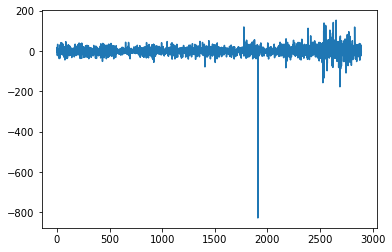

In [47]:
plt.plot(stock_differenced)
# plt.ylim(-800, 400)

In [49]:
X = train_set
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.917997
p-value: 0.043295
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [50]:
X = test_set
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.884199
p-value: 0.793131
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569


#### Plot ACF plots of full time series, train and test set

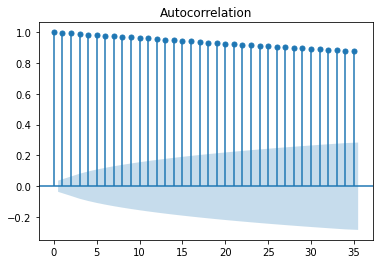

In [51]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(price['Close'])
plt.show()

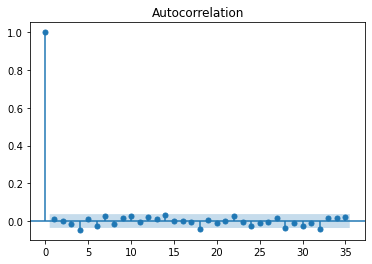

In [60]:
plot_acf(stock_differenced, alpha=0.05)
plt.show()

<b><i> For white noise series, we expect each autocorrelation to be close to zero. Of course, they will not be exactly equal to zero as there is some random variation. For a white noise series, we expect 95% of the spikes in the ACF to lie within  +-2/math.sqrt(T) where, T
is the length of the time series. (Source: https://otexts.com/fpp2/wn.html#wn)</b></i> </br></br>

<i>White noise series is i.i.d and therefore we can use ECDF distance measures like it is used for image dataset (i.i.d) earlier.</i>


<i>After making time series stationary, use this differenced data to train the model and also to measure ECDF distances</i>

In [14]:
stock_differenced.mean()

0.3980304077401521

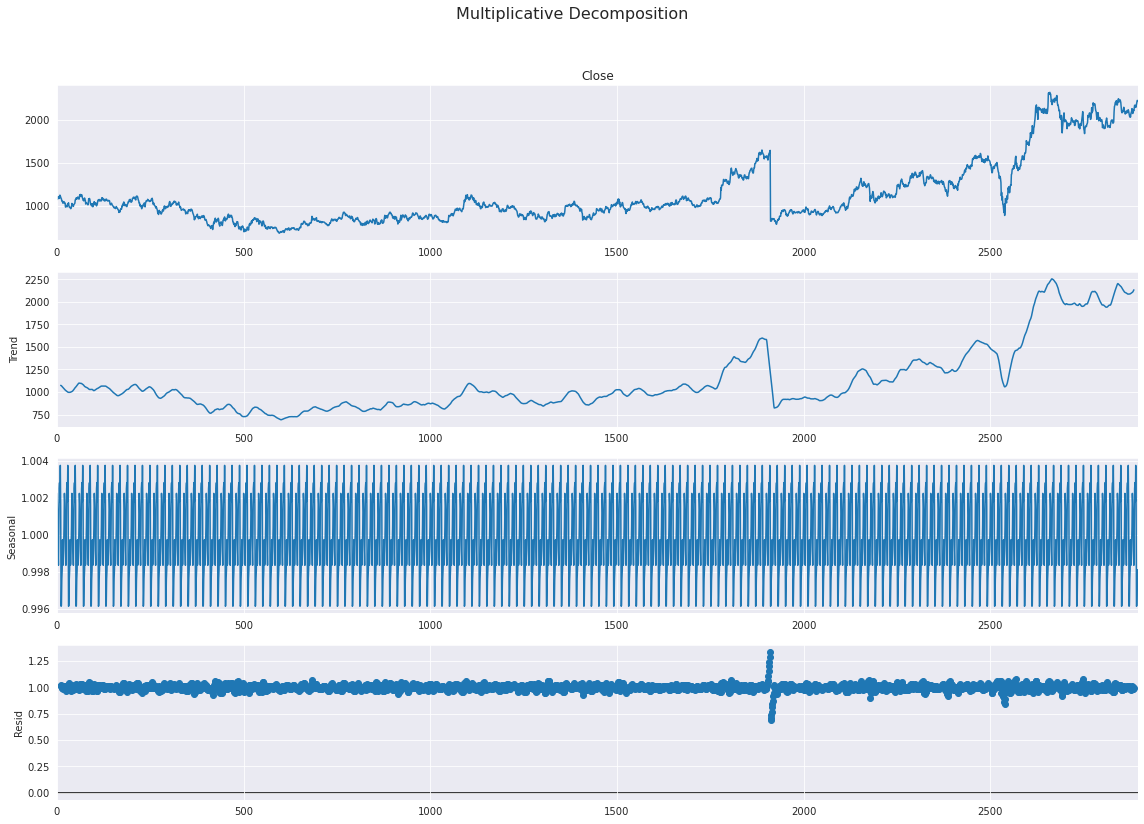

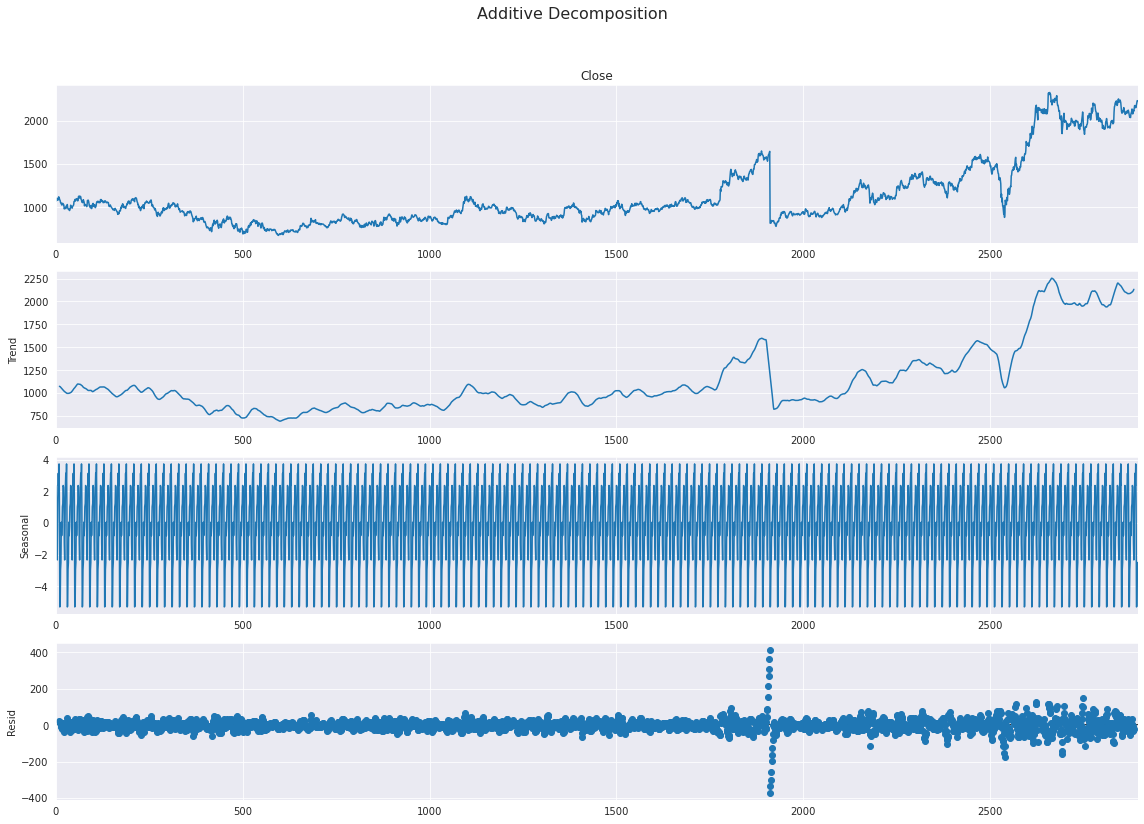

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose


# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(price['Close'], model='multiplicative', period=20)

# Additive Decomposition
additive_decomposition = seasonal_decompose(price['Close'], model='additive', period=20)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [8]:
price_log = np.log(price['Close'])

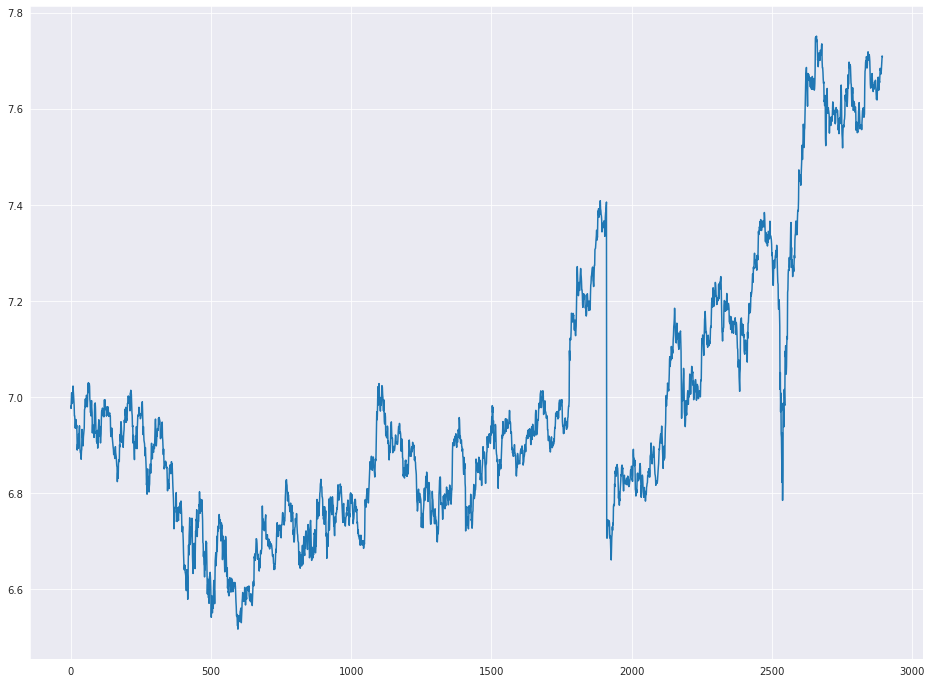

In [9]:
plt.plot(price_log)